# Calibration, Calculating ADC / MeV Based on Muon Peak (vz1)

#### Din-Ammar Tolj, Emily Pottebaum
Heeger-Maruyama Group, Summer 2023

To use, change sourceFolder to the data folder that you want to calibrate and run all the cells. This outputs a ADC/MeV ratio based on the Muon peak.

### Import needed libraries

In [2]:
import ROOT

import sys
import math

import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=14)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['ytick.major.size'] = 8

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.linewidth'] = 1.2 # set the value globally

# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=22)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

# Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
%cd libs/
from dt5202 import dt5202_crunch
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ
ped = 50 #pedestal correction

# Import Langaus fit curve for PyROOT.
from langaus import LanGausFit
%cd -
from root_numpy import array2hist, hist2array, fill_hist

Welcome to JupyROOT 6.24/02


/tmp/ipykernel_4367/892063941.py:29: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build
/vast/palmer/home.grace/dt592/Geant4Work


### Load and read lab data from directory

In [3]:
# sourceFolder = "/home/dt592/data/CsSwirlyDin1_20230710/"
sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"
# sourceFolder = "/home/dt592/data/Co-60-SwirlyDin1-2min-20230717/"

#folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory0
onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
# print(onlyfiles)
data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

#f = sourceFolder+'Run0_list.dat'
#data = dt5202_crunch(f, num_ev=10000000, num_ch=2)

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))


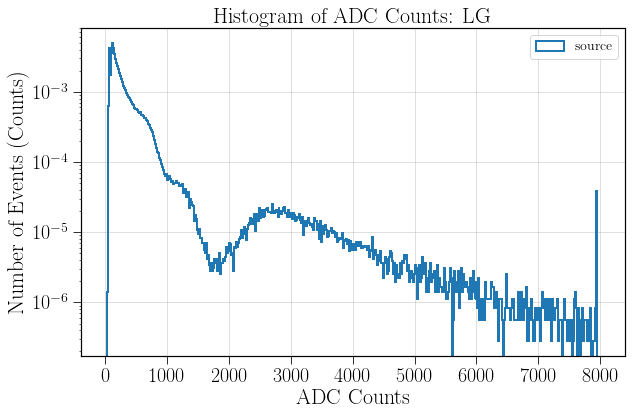

In [4]:
plt.figure(figsize=(9,6))

plt.hist(data['data']['low_gain'], bins=500, range=(0,8000),
        histtype='step', label = "source", lw = 2, density=True);
plt.yscale('log')

plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts: LG')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist_HighGainBigPanel.png')

### Calibrate imported data by Muon Peak, calculate ADC/MeV

In [5]:
c1 = ROOT.TCanvas('c1','')
hpx = ROOT.TH1D('Landau-Gauss Fit','pls',500,0,9000)
fill_hist(hpx, np.array(data['data']['low_gain']))

/gpfs/gibbs/project/maruyama/dt592/conda_envs/ROOT6/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(


 FCN=628.281 FROM MIGRAD    STATUS=CONVERGED     495 CALLS         496 TOTAL
                     EDM=6.73302e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   3.56111e+02   5.39112e+00  -2.22603e-03   2.33539e-05
   2  LandauMPV    2.69198e+03   8.43722e+00   1.07155e-01   1.11698e-04
   3  Normalisation   5.95077e+04   9.14898e+02  -6.27687e-02  -7.87909e-07
   4  GaussianSigma   2.60985e+00   4.97565e-02   6.14136e-04  -1.95011e-02
                               ERR DEF= 0.5


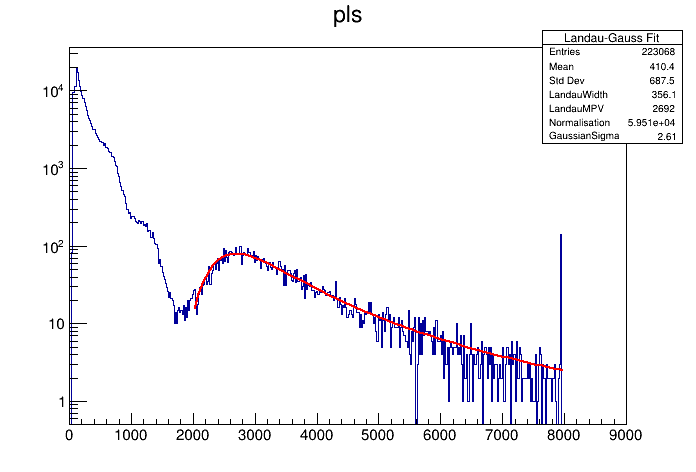

In [7]:
hpx.Draw()
ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(hpx,fitrange=(2000,8000))
hpx.Draw()
func.Draw("same")
c1.Draw()

In [8]:
MPV = func.GetParameter(1) # this corresponds to the most probable value of the distribution
print("MPV:", MPV)
ADCperMEV = MPV/5.0
print("ADC/MeV:", ADCperMEV)

MPV: 2691.9774006184944
ADC/MeV: 538.3954801236989


In [13]:
2691.9774006184944 / 4.95

543.8338183067665